# State of Charge/State of Health Estimation Framework using Center for Advanced Life Cycle Engineering Data

In [1]:
# Load all necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import warnings
# Filter unnecessary warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Load helper scripts
%load_ext autoreload
%autoreload 2
import helper_functions as help_func
import config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load CALCE data and fix data recording issues
df_35_subcycle = help_func.extract_data(config.cs2_35_dates, 'data/CS2_35/CS2_35_', 'Channel_1-008')
df_35_subcycle.insert(loc=0, column='Cell_Number', value=35)

df_36_subcycle = help_func.extract_data(config.cs2_36_dates, 'data/CS2_36/CS2_36_', 'Channel_1-009')
df_36_subcycle.insert(loc=0, column='Cell_Number', value=36)

df_37_subcycle = help_func.extract_data(config.cs2_37_dates, 'data/CS2_37/CS2_37_', 'Channel_1-010')
df_37_subcycle.insert(loc=0, column='Cell_Number', value=37)

df_38_subcycle = help_func.extract_data(config.cs2_38_dates, 'data/CS2_38/CS2_38_', 'Channel_1-011')
df_38_subcycle.insert(loc=0, column='Cell_Number', value=38)

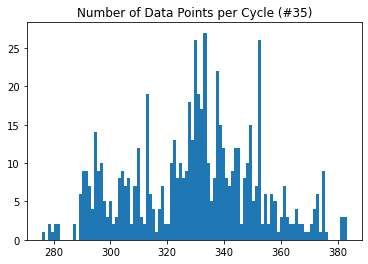

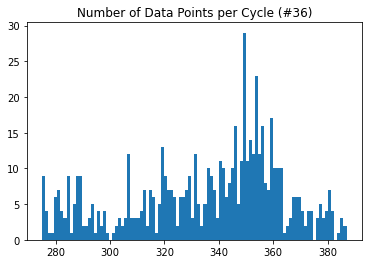

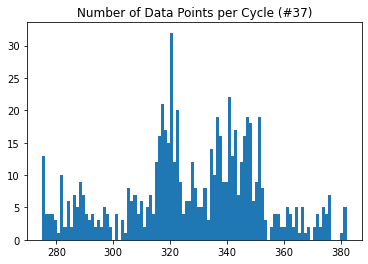

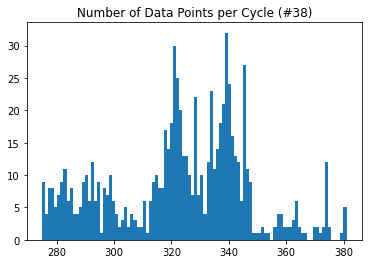

In [5]:
# Look at number of data points per cycle
df_35_lengths = df_35_subcycle.groupby('Cycle_Index').size().reset_index()
plt.hist(df_35_lengths[0], 100)
plt.title('Number of Data Points per Cycle (#35)')
plt.show()

df_36_lengths = df_36_subcycle.groupby('Cycle_Index').size().reset_index()
plt.hist(df_36_lengths[0], 100)
plt.title('Number of Data Points per Cycle (#36)')
plt.show()

df_37_lengths = df_37_subcycle.groupby('Cycle_Index').size().reset_index()
plt.hist(df_37_lengths[0], 100)
plt.title('Number of Data Points per Cycle (#37)')
plt.show()

df_38_lengths = df_38_subcycle.groupby('Cycle_Index').size().reset_index()
plt.hist(df_38_lengths[0], 100)
plt.title('Number of Data Points per Cycle (#38)')
plt.show()

In [6]:
# Get cycling data from subcycle information
df_35 = help_func.extract_cycle_data(df_35_subcycle, 35)
df_36 = help_func.extract_cycle_data(df_36_subcycle, 36)
df_37 = help_func.extract_cycle_data(df_37_subcycle, 37)
df_38 = help_func.extract_cycle_data(df_38_subcycle, 38)

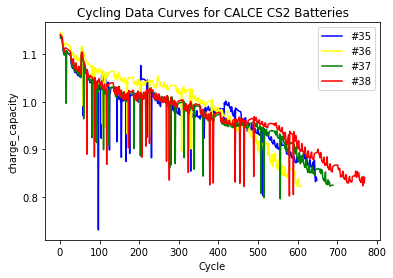

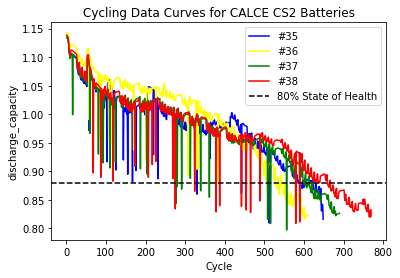

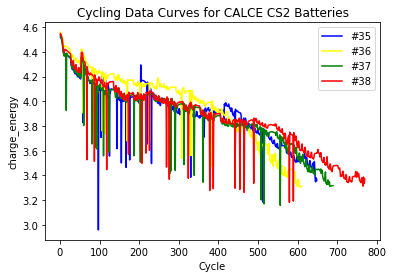

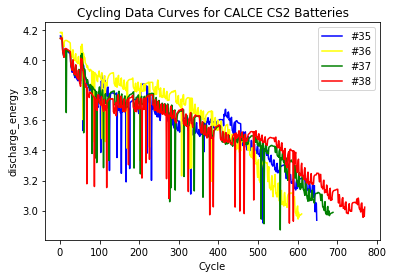

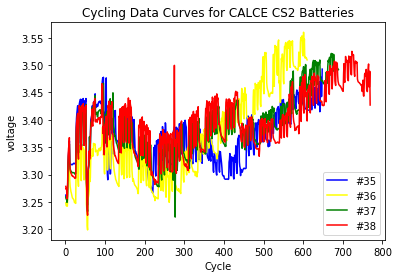

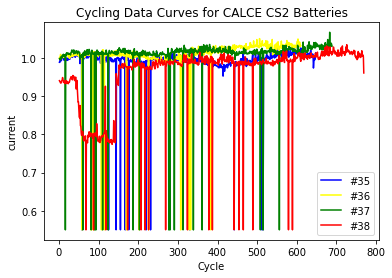

In [7]:
# Plot cycling data's available features 
for col in config.col_for_filtering:
    plt.plot(df_35['cycle'], df_35[col], color='blue', label='#35')
    plt.plot(df_36['cycle'], df_36[col], color='yellow', label='#36')
    plt.plot(df_37['cycle'], df_37[col], color='green', label='#37')
    plt.plot(df_38['cycle'], df_38[col], color='red', label='#38')
    if col == 'discharge_capacity':
        plt.axhline(y=config.nominal_capacity*config.eol, color='black', linestyle='--', label='80% State of Health')
    plt.legend()
    plt.title('Cycling Data Curves for CALCE CS2 Batteries')
    plt.xlabel('Cycle')
    plt.ylabel(col)
    plt.show()

In [8]:
# Use time series outlier detection function to filter data
df_35_filtered = help_func.filter_outliers_local(df_35, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)
df_36_filtered = help_func.filter_outliers_local(df_36, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)
df_37_filtered = help_func.filter_outliers_local(df_37, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)
df_38_filtered = help_func.filter_outliers_local(df_38, config.col_for_filtering, config.std_window, config.diff_window, config.iqr_cut)

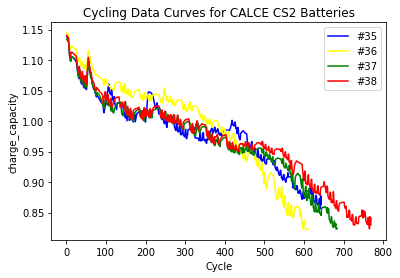

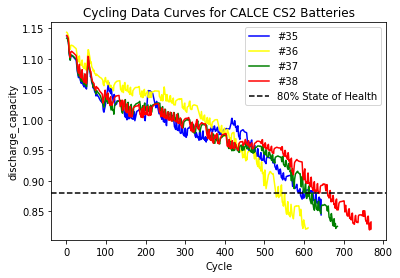

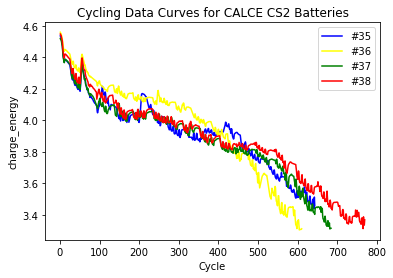

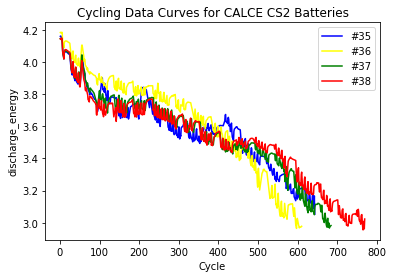

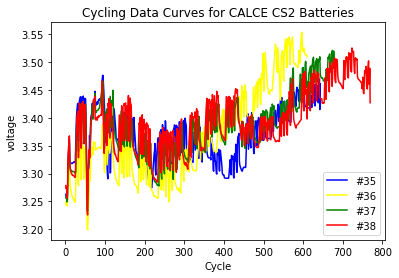

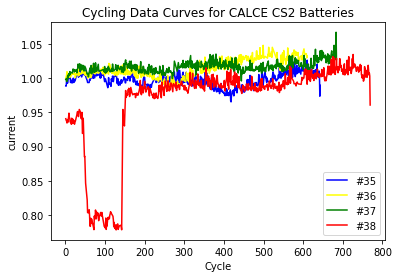

In [9]:
# Plot cycling data's available features after filtering outliers
for col in config.col_for_filtering:
    plt.plot(df_35_filtered['cycle'], df_35_filtered[col], color='blue', label='#35')
    plt.plot(df_36_filtered['cycle'], df_36_filtered[col], color='yellow', label='#36')
    plt.plot(df_37_filtered['cycle'], df_37_filtered[col], color='green', label='#37')
    plt.plot(df_38_filtered['cycle'], df_38_filtered[col], color='red', label='#38')
    if col == 'discharge_capacity':
        plt.axhline(y=config.nominal_capacity*config.eol, color='black', linestyle='--', label='80% State of Health')
    plt.legend()
    plt.title('Cycling Data Curves for CALCE CS2 Batteries')
    plt.xlabel('Cycle')
    plt.ylabel(col)
    plt.show()

In [10]:
# Calculate at which cycle batteries drop below 80% state of health and chop cycling and subcycle data at the 80% eol cycle
df_35_eol = help_func.create_target(df_35_filtered, config.nominal_capacity*config.eol)
df_36_eol = help_func.create_target(df_36_filtered, config.nominal_capacity*config.eol)
df_37_eol = help_func.create_target(df_37_filtered, config.nominal_capacity*config.eol)
df_38_eol = help_func.create_target(df_38_filtered, config.nominal_capacity*config.eol)

df_35_subcycle_eol = df_35_subcycle[df_35_subcycle['Cycle_Index'] <= df_35_eol['eol_cycle'].iloc[0]]
df_36_subcycle_eol = df_36_subcycle[df_36_subcycle['Cycle_Index'] <= df_36_eol['eol_cycle'].iloc[0]]
df_37_subcycle_eol = df_37_subcycle[df_37_subcycle['Cycle_Index'] <= df_37_eol['eol_cycle'].iloc[0]]
df_38_subcycle_eol = df_38_subcycle[df_38_subcycle['Cycle_Index'] <= df_38_eol['eol_cycle'].iloc[0]]

In [11]:
df_35_subcycle_soc_soh, df_35_soc_soh = help_func.calculate_soc_soh(df_35_eol, df_35_subcycle_eol, config.nominal_capacity)
df_36_subcycle_soc_soh, df_36_soc_soh = help_func.calculate_soc_soh(df_36_eol, df_36_subcycle_eol, config.nominal_capacity)
df_37_subcycle_soc_soh, df_37_soc_soh = help_func.calculate_soc_soh(df_37_eol, df_37_subcycle_eol, config.nominal_capacity)
df_38_subcycle_soc_soh, df_38_soc_soh = help_func.calculate_soc_soh(df_38_eol, df_38_subcycle_eol, config.nominal_capacity)

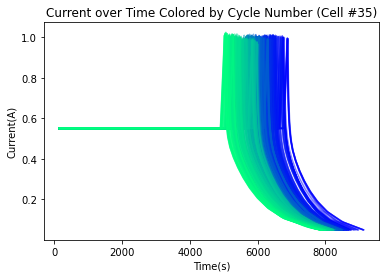

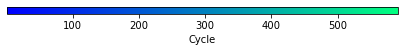

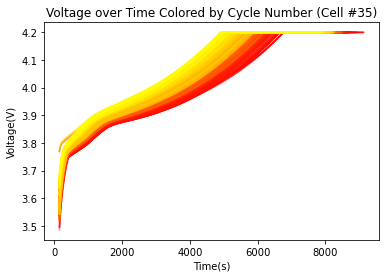

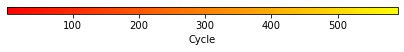

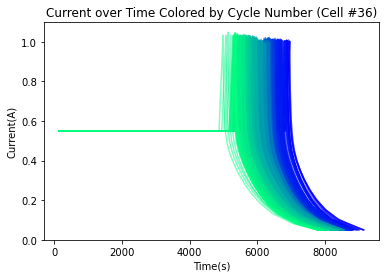

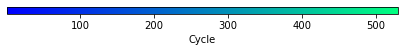

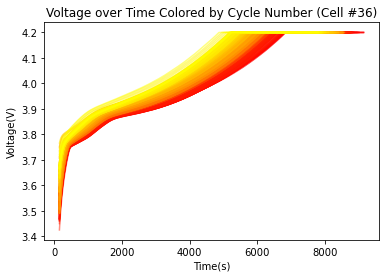

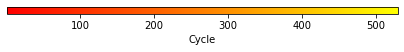

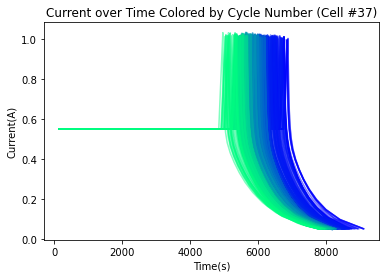

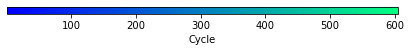

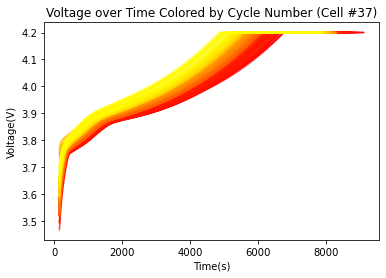

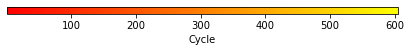

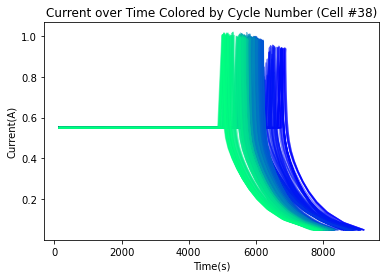

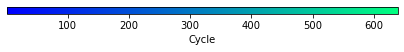

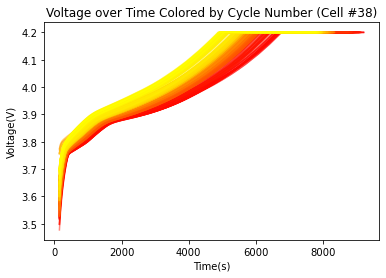

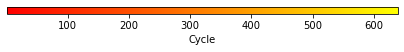

In [12]:
help_func.plot_subcycle_data(df_35_subcycle_soc_soh, 'Current(A)', 'winter', mpl.cm.winter, 'Current over Time Colored by Cycle Number (Cell #35)')
help_func.plot_subcycle_data(df_35_subcycle_soc_soh, 'Voltage(V)', 'autumn', mpl.cm.autumn, 'Voltage over Time Colored by Cycle Number (Cell #35)')

help_func.plot_subcycle_data(df_36_subcycle_soc_soh, 'Current(A)', 'winter', mpl.cm.winter, 'Current over Time Colored by Cycle Number (Cell #36)')
help_func.plot_subcycle_data(df_36_subcycle_soc_soh, 'Voltage(V)', 'autumn', mpl.cm.autumn, 'Voltage over Time Colored by Cycle Number (Cell #36)')

help_func.plot_subcycle_data(df_37_subcycle_soc_soh, 'Current(A)', 'winter', mpl.cm.winter, 'Current over Time Colored by Cycle Number (Cell #37)')
help_func.plot_subcycle_data(df_37_subcycle_soc_soh, 'Voltage(V)', 'autumn', mpl.cm.autumn, 'Voltage over Time Colored by Cycle Number (Cell #37)')

help_func.plot_subcycle_data(df_38_subcycle_soc_soh, 'Current(A)', 'winter', mpl.cm.winter, 'Current over Time Colored by Cycle Number (Cell #38)')
help_func.plot_subcycle_data(df_38_subcycle_soc_soh, 'Voltage(V)', 'autumn', mpl.cm.autumn, 'Voltage over Time Colored by Cycle Number (Cell #38)')

In [19]:
# Save data to avoid having to redoing parsing, chopping, target creation, and cleaning
df_subcycle = pd.concat([df_35_subcycle_soc_soh, df_36_subcycle_soc_soh, df_37_subcycle_soc_soh, df_38_subcycle_soc_soh])
df_subcycle.to_csv('data/calce_subcycle_data.csv', index=False)
df = pd.concat([df_35_soc_soh, df_36_soc_soh, df_37_soc_soh, df_38_soc_soh])
df.to_csv('data/calce_cycling_data.csv', index=False)

In [21]:
# Load saved data for faster use
df_subcycle = pd.read_csv('data/calce_subcycle_data.csv')
df = pd.read_csv('data/calce_cycling_data.csv')

In [22]:
df_subcycle.head()

,Cell_Number,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),...,Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),State_of_Health,Full_Charge_Capacity,State_of_Charge
0,35,6,150.093538,2010-08-17 14:32:57,30.015324,2,1,0.549936,3.639367,0.004587,...,0.016597,0.0,0.001004,0.0,0,0,0,1.035133,1.138646,0.004028
1,35,7,180.108590,2010-08-17 14:33:27,60.030376,2,1,0.550117,3.671582,0.009174,...,0.033367,0.0,0.000809,0.0,0,0,0,1.035133,1.138646,0.008057
2,35,8,210.123906,2010-08-17 14:33:57,90.045692,2,1,0.550297,3.697807,0.013760,...,0.050270,0.0,0.000648,0.0,0,0,0,1.035133,1.138646,0.012085
3,35,9,240.139013,2010-08-17 14:34:27,120.060799,2,1,0.550297,3.720148,0.018347,...,0.067283,0.0,0.000550,0.0,0,0,0,1.035133,1.138646,0.016113
4,35,10,270.154334,2010-08-17 14:34:57,150.076120,2,1,0.550117,3.739736,0.022934,...,0.084392,0.0,0.000486,0.0,0,0,0,1.035133,1.138646,0.020141


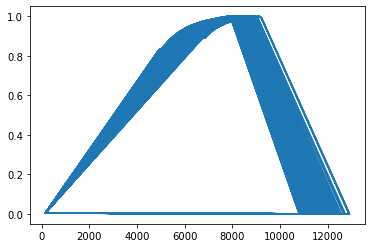

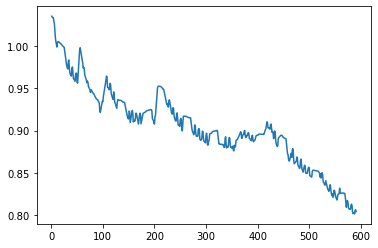

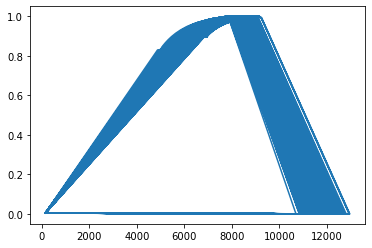

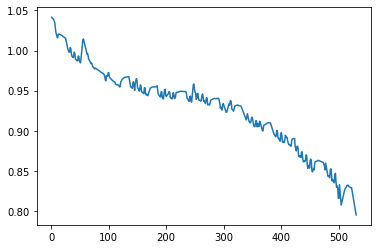

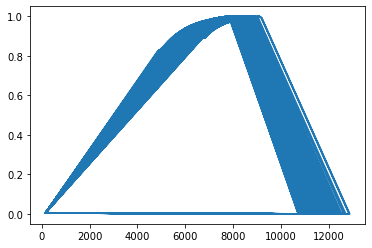

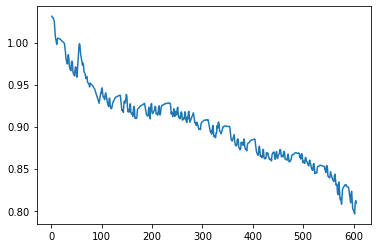

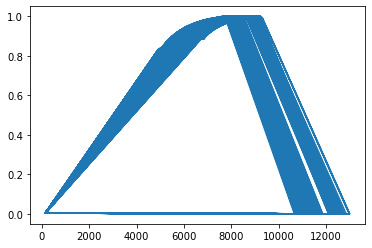

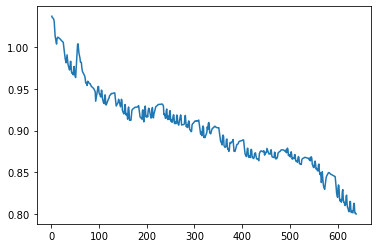

In [27]:
# Check SOC/SOH calculation
df_plot = df_subcycle[df_subcycle['Cell_Number'] == 35]
plt.plot(df_plot['Test_Time(s)'], df_plot['State_of_Charge'])
plt.show()

plt.plot(df_plot.Cycle_Index.unique(), df_plot.State_of_Health.unique())
plt.show()

df_plot = df_subcycle[df_subcycle['Cell_Number'] == 36]
plt.plot(df_plot['Test_Time(s)'], df_plot['State_of_Charge'])
plt.show()

plt.plot(df_plot.Cycle_Index.unique(), df_plot.State_of_Health.unique())
plt.show()

df_plot = df_subcycle[df_subcycle['Cell_Number'] == 37]
plt.plot(df_plot['Test_Time(s)'], df_plot['State_of_Charge'])
plt.show()

plt.plot(df_plot.Cycle_Index.unique(), df_plot.State_of_Health.unique())
plt.show()

df_plot = df_subcycle[df_subcycle['Cell_Number'] == 38]
plt.plot(df_plot['Test_Time(s)'], df_plot['State_of_Charge'])
plt.show()

plt.plot(df_plot.Cycle_Index.unique(), df_plot.State_of_Health.unique())
plt.show()

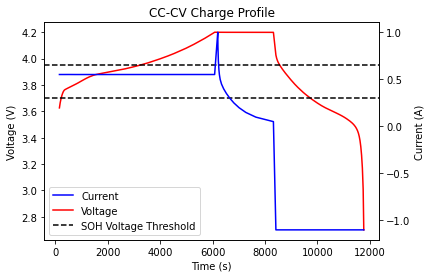

In [40]:
# Plot one cycle of the charge distrubtuion to get an idea of what CC/CV looks like and the voltage range used for SOH
df_subcycle_temp = df_subcycle[(df_subcycle['Cycle_Index'] == 100) & (df_subcycle['Cell_Number'] == 35)]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
steps = list(df_subcycle_temp.Step_Index.unique())
ax1.plot(df_subcycle_temp['Test_Time(s)'], df_subcycle_temp ['Voltage(V)'], color='red', label='Voltage') 
ax2.plot(df_subcycle_temp['Test_Time(s)'], df_subcycle_temp['Current(A)'], color='blue', label='Current') 
ax1.axhline (y=3.7, color = 'black', Linestyle= '--', label='SOH Voltage Threshold')
ax1.axhline (y=3.95, color = 'black', Linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax2.set_ylabel('Current (A)')
plt.title('CC-CV Charge Profile')
for s in steps:
    df_temp = df_subcycle_temp[df_subcycle_temp['Step_Index']==s]
    max_time = max(df_temp['Test_Time(s)'])
    l = 'End Step' + str(s)
#plt.axvLine(x = max_time, color = 'black', Label = L, Linestyle='--') 
plt.plot([], [], color='red', label='Voltage')
plt.plot([], [], color='black', LInestyle='--', label='SOH Voltage Threshold')
plt.legend(loc=3)